# 2C: Language model surprisal and EEG data

_by Jelle Zuidema, September 2022_

This notebook is based on _[Rasyan Ahmed's master thesis code](https://github.com/Rasyan/Thesis)_. Goal of the notebook is to introduce you to an interesting dataset (the EEG data collected by _[Broderick et al., 2018](https://doi.org/10.1016/j.cub.2018.01.080)_ from subjects listening to an audiobook), and to show an example of how next word probabilities as computed by a modern Deep Language Model can be successfully used to predict some aspect of language processing in the brain.

### load required libraries

In [ ]:
!pip install mne==0.20.7

In [ ]:
!pip install -q scipy #transformers 

In [ ]:
import scipy.io as sio
import numpy as np

import mne
from mne.decoding import ReceptiveField
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm

import random

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

### make datasets available

Add shortcuts to drive: (JZ: how do these become shortcuts rather than downloads?)
- [Subject19.zip](https://drive.google.com/file/d/1ZWopKDEf1FPDciVPATcUrAkF8XY0WgK6/view?usp=sharing)
- [Stimuli.zip](https://drive.google.com/file/d/1c04Z8YNUjoRkGfNu2zGQDM6gFpRs-Cab/view?usp=sharing)
- [vectors.zip](https://drive.google.com/file/d/1yF3PK94RFRxZyMuQHHOk8iS7yZMMJ15j/view?usp=sharing)
- [results.zip](https://drive.google.com/file/d/1lXNhl3WUK48Juj0oA-itR_tkONdlK2G4/view?usp=sharing)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip -qq '/content/drive/MyDrive/Subject19.zip'
!unzip -qq '/content/drive/MyDrive/Stimuli.zip'
!unzip -qq '/content/drive/MyDrive/vectors.zip'
!unzip -qq '/content/drive/MyDrive/results.zip'

In [ ]:
# Alternatively, download the files above and upload them to colab/wherever you run this notebook 
#!unzip -qq 'Subject19.zip'
#!unzip -qq 'Stimuli.zip'
#!unzip -qq 'vectors.zip'
#!unzip -qq 'results.zip'

#Loading and preprocessing the EEG data

In [ ]:
#@title Helper function 1: load_eeg_and_dissimilarity_vector()

def load_eeg_and_disimilarlity_vector(sim, method):

    # flatten the similarity values (from 3D list to 1D list)
    flat_sim = [word for sentence in [sentence for run in sim for sentence in run] for word in sentence]
    
    # normalize to the values of the broderick similarity values.
    normalise = norm/np.mean(flat_sim)
     
    # 
    raw_subs = []
    ms_subs = []
    dis_vector_subs = []

    for sub in tqdm(subs):  # for each subject
        raw = []
        ms = []
        dis_vector = []
        #print('Load eeg & dissimilarity values: subject: ', sub, "/", len(subs), end = "\r", flush=True)

        for i in range(1,21):  # for each run

            # load data
            data = sio.loadmat(eeg_location + str(sub) + "/Subject" + str(sub) + "_Run" + str(i) +  ".mat")
            raw_i = data['eegData'].T
            ms_i = data['mastoids'].T
            loc = stimuli_location + "/Run" + str(i) + ".mat"
            words = sio.loadmat(loc)

            # create list of word similaritys in order and normalise.
            norm_flat_sim = [simz * normalise for sentence in sim[i-1] for simz in sentence]

            if len(norm_flat_sim)!= len(words['onset_time']):
                print(sub,i, len(norm_flat_sim), len(words['onset_time']))

            # create empty vector of same size as the eeg.
            dis_vector_i = np.zeros((1,raw_i.shape[1]))
            
            if method == 'random_loc': 
                random_locations = random.sample(range(0,raw_i.shape[1]), len(norm_flat_sim))
            
            #print(asdfasdfasdfasdf)
            # for each word, find its onset, and then place it there in the empty vector.
            for j in range(len(norm_flat_sim)):
                
                if method == 'random_loc':
                    on = random_locations[j]
                else: 
                    on = int(np.floor(words['onset_time'][j] * sfreq))
                    
                dis_vector_i[0][on] = (1-norm_flat_sim[j]) 
            

            
                # This is also where the random vectors and such are created. 
                # comment out to do something else than the normal method


                # dis_vector_i[0][on] = 0.33820258789060476                     # one at onset
                # dis_vector_i[0][on] = random.uniform(0, 1)  # random value on onset

    #         for i in range(1,len(dis_vector_i[0])):          # value at specific or all times
    #             dis_vector_i[0][i] = 1


            raw.append(raw_i)     
            dis_vector.append(dis_vector_i)
            ms.append(ms_i)

        raw_subs.append(raw)
        ms_subs.append(ms)
        dis_vector_subs.append(dis_vector)
        
    print('Load eeg & dissimilarity values: Done')
    return(dis_vector_subs,ms_subs,raw_subs)


In [ ]:
# define location, filename, subject number and number of segments in the dataset

# location of files
eeg_location = "Subject"            # "/content/drive/MyDrive/Subject" # -- check what these should be
stimuli_location = "Stimuli/Text"   # "/content/drive/MyDrive/Stimuli/Text"
vector_loc = "vectors/"             # "/content/drive/MyDrive/vectors/"
results_folder = 'results/'         # "/content/drive/MyDrive/results/"

# details of the dataset we will use
subs = [19]
n_runs = 20 # number of runs (which we will call "segments" here)

# frequency of the EEG data
sfreq = 128

# number of channels
n_channels = 128

# Define the delays that we will use in the receptive field (0 = event, so this means we take into account upto 0.6seconds after event)
tmin, tmax = 0, .6

# the mean similarity for the broderick method, everything is normalised to this.
norm = 0.33820258789060476

In [ ]:
vector = 'bert_4_False' # use word likehoods obtained from a Bert model, with access to 4 prior words and no access to future context
similarity_location = vector_loc +  vector + '.npy'
sim = np.load(similarity_location, allow_pickle=True)
dis_vector, raw_mastoids, raw_eeg = load_eeg_and_disimilarlity_vector(sim, vector)

  0%|          | 0/1 [00:00<?, ?it/s]

Load eeg & dissimilarity values: Done


In [ ]:
#@title Helper function 2: process_eeg()

def process_eeg(dis_vector, raw_mastoids, raw_eeg, var_limit): 
    
    fixes = 0
    fixes2 = 0
    subject_data = []
    for sub in tqdm(subs):
        #print('Process eeg: subject: ', sub, "/", len(subs), end = "\r", flush=True)
        raws = np.empty((20,), dtype=object)
        ms = np.empty((20,), dtype=object)
        dv = np.empty((20,), dtype=object)
        filterd = np.empty((20,), dtype=object)
        data = {}
        for i in range(1,21):

            # load data of the prev cell
            raws[i-1] = raw_eeg[subs.index(sub)][i-1].T
            ms[i-1] = raw_mastoids[subs.index(sub)][i-1].T
            dv[i-1] = dis_vector[subs.index(sub)][i-1].T


            # add mastoids as the last two channels.
            raw = np.concatenate((raw_eeg[subs.index(sub)][i-1],raw_mastoids[subs.index(sub)][i-1]))
            
            
            montage = mne.channels.make_standard_montage('biosemi128');
            montage.ch_names = montage.ch_names + ['M1', 'M2']
            montage.dig = montage.dig + [montage.dig[4],montage.dig[5]]
            

            info = mne.create_info(montage.ch_names[:130], sfreq, 'eeg', montage=montage)
            raw = mne.io.RawArray(raw, info)
            raw.add_channels


            # remove the standerd reference mne sets upon it.
            raw, _ = mne.set_eeg_reference(raw, [])

            # reference instead using the average of the last two channels (mastoids)
            raw, _ = mne.set_eeg_reference(raw, montage.ch_names[128:130])

            # bandpass filter the data without the mastoids
            #raw.info['bad'] = montage.ch_names[128:130]
            raw = raw.drop_channels(montage.ch_names[128:130])
            raw = raw.filter(1,8)
            
            test = raw.get_data()
        
            var = [np.var(channel[1280:-1280]) for channel in test]
            raw.info['bads'] = np.array(montage.ch_names[:128])[np.array(var[:128])>var_limit]
            fixes2 += raw.info['bads'].size
            if raw.info['bads'].size > 0: fixes +=1
            raw.interpolate_bads()
            
            #print(raw.get_data.size())
            filt = raw.get_data()
            filterd[i-1] = filt[:128].T   

        data['raw'] = raws
        data['ms'] = ms
        data['dv'] = dv
        data['filterd'] = filterd
        subject_data.append(data)
    
    print('Process eeg: Done')
    print("Total fixes: ", fixes)
    print("Total fixes: ", fixes2)
    return(subject_data)


In [ ]:
# Run standard EEG preprocessing on the dataset to filter signal outside the 1-8Hz bandwidth and remove noise in the data
data = process_eeg(dis_vector, raw_mastoids, raw_eeg, 100000)

Now that we have loaded and processed the data, it is time to have a look at the original EEG measurements and the effects of preprocessing. The original data is available as data['raw']; the filter data as data['filterd'].


In [ ]:
the_data = data[0]
eeg_before = the_data['raw']
eeg_after = the_data['filterd']

In [ ]:
#let's decide what parts of the data to look at
which_segments = range(10,12) # let's focus on a middle piece, say segments 10,11 and 12. 
channel_number = 20 # let's focus on one channel

ourchannel_eeg_after = [(eeg_after[i]).transpose()[channel_number] for i in which_segments] #range(n_segments)]
ourchannel_eeg_before = [(eeg_before[i]).transpose()[channel_number] for i in which_segments] #in range(n_segments)]

timeseries_before = np.concatenate(ourchannel_eeg_before)
timeseries_after = np.concatenate(ourchannel_eeg_after)


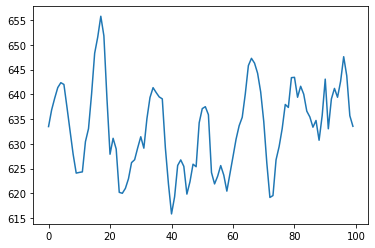

In [ ]:
# and plot the timeseries
plt.plot(timeseries_before[9000:9100])

# Assignment 1

Plot some fragments from both the before and after timeseries, and investigate -- in rough outline -- what the preprocessing has done to the data. 

# Training the TRFs (or not)

In [ ]:
#@title Helper functions 3 & 4: TRF() and train()

def TRF(subject_data, start=0, end=1, save=None, shuffle=False, second_folder = 'randoms/'):
    
    for run in tqdm(range(start,end)):
    
        #print('run', run)
        scores_subs=[]
        coefs_subs=[]
        error_subs=[]
        for sub in tqdm(subs):

            # run value as random seed. makes reproduction possible if we need extra info later on.
            random.seed(run)
            data = subject_data[subs.index(sub)]
            dv = np.vstack(data['dv'])

            if shuffle:
                # create a list of all disimilarity values.
                ddv = np.array([d for d in dv if d>0])

                # shuffle this list.
                random.shuffle(ddv)

                # for each non 0 in real dissimilarity vector
                i = 0
                for j in range(len(dv)):
                    if dv[j] > 0:

                        # add the i element of the shuffled list of dissimilarity values.
                        dv[j] = ddv[i]
                        i+=1

            Y = np.vstack(data['filterd']) 

            # normalisation method. basicly just subtracts the average and devides by the standerd deviations
            scaler = StandardScaler()           # initalise scaler
            scaler.fit(Y)                       # finds the average and sd
            Y = scaler.transform(Y)      # scales each value.


            #Initialize the model
            rf = ReceptiveField(tmin, tmax, sfreq, feature_names=['envelope'],
                                estimator=1., scoring='corrcoef')

            # calculate how many items there are between the delays
            n_delays = int((tmax - tmin) * sfreq) + 2

            # setup 5fold CV
            n_splits = 5
            cv = KFold(n_splits)

            DV = np.array([dv[i-78:i,] for i in range(78,dv.shape[0])])

            # Simple linear regression for each time step using 5fold CV
            coefs = np.zeros((n_splits, n_channels, n_delays))
            scores = np.zeros((n_splits, n_channels))

            err= []
            # Iterate through splits, fit the model, and predict/test on held-out data
            for ii, (train, test) in enumerate(cv.split(dv)):  # split the data 4:1 (train:test) for each different way.
                #print('split %s / %s' % (ii + 1, n_splits))

                rf.fit(dv[train], Y[train])

                scores[ii] = rf.score(dv[test], Y[test])
                # coef_ is shape (n_outputs, n_features, n_delays). we only have 1 feature
                coefs[ii] = rf.coef_[:, 0, :]

                # calculate errors

                W = np.flip(coefs[ii],1) # define Weights as the flipped coefs
                #print(test)

                test=test[test>=78] # remove the first 78 values, as we dont have full data for them
                test=test -78 
                #print(test)
                DV2 = DV[test] # select only the dissimilarity values for the test set
                real = Y[test]

                DVs = np.sum(DV2,1) 
                mask = [s for s in range(0,len(DV2)) if DVs[s]!=0]
                DV2 = DV2[mask] # remove all test cases with 0 dv values
                real = real[mask]

                pred = np.array([W @ s for s in DV2]).squeeze() # calculate predicted value.

                m = np.mean(real,0)
                SStot = np.sum((real-m)**2,0)
                SSreg = np.sum((pred-m)**2,0)
                SSres = np.sum((real-pred)**2,0)
                r2 = 1-(SSres/SStot)
                errors = np.array([SStot,SSreg,SSres,r2])

                err.append(errors)

            times = rf.delays_ / float(rf.sfreq)

            scores_subs.append(scores)
            coefs_subs.append(coefs)
            error_subs.append(err)
        
        if shuffle==True and save and ((end-start)>1):
            # save results
            saveFunc(loc, run_string , scores_subs, coefs_subs, error_subs, length)
    
    return(scores_subs, coefs_subs, error_subs) # save last run results

def train(vector, preprocess = 100000, backup = 'pearson', start=0, end=1, save=True, shuffle=False):
    
    if vector == 'random_loc':
        similarity_location = vector_loc +  backup + '.npy'
    else:
        similarity_location = vector_loc +  vector + '.npy'
    
    # loads the similarity values 
    sim = np.load(similarity_location, allow_pickle=True)
    
    dis_vector, raw_mastoids, raw_eeg = load_eeg_and_disimilarlity_vector(sim, vector)
    data = process_eeg(dis_vector, raw_mastoids, raw_eeg, preprocess)
    
    scores_subs, coefs_subs, error_subs = TRF(data)
    #scores_subs, coefs_subs, error_subs = TRF(data, start=3, end=100, save=save, shuffle=True, second_folder)
    
    if end-start > 1:
        combine_multi_runs()
    
    if save:
        if vector == 'pearson':
            run_string = vector + '_' + str(preprocess)
            
        elif vector[:4] == 'bert':
            run_string = vector + '_' + str(preprocess)
            
        elif vector == 'static':
            run_string = vector + '_' + str(preprocess)
        
        elif vector == 'random_loc':
            run_string = vector + '(' + backup + ")" + '_' + str(preprocess)
        
        elif shuffle:
            run_string = 'shuffle(' + vector + ')' + '_' + str(preprocess)
        
        saveFunc(results_folder, run_string, scores_subs, coefs_subs, error_subs, end-start)

    return(scores_subs, coefs_subs, error_subs)
    
#scores_subz, coefs_subz, error_subz = train(vector_loc, method,  999999999999999999)


We can now train a temporal response function (TRF) by using helper functions 3 and 4. This is, however, quite time consuming. To save time, we will used the precomputed TRF's that are available in the results folder (after you have unzipped results.zip).

# Plotting the obtained TRF coefficients

In [ ]:
#@title Helper function 5: plot_curve()

def plot_curve(ch,sd,ax,title):
    i = 0
    j = 0
    for tup in plot_data:
        if tup[3] == "single":
            ax.plot(times,coefs[i][ch], label= tup[1])
            i+=1

        elif tup[3] == "multi":
            ax.plot(times,multi_coefs_avg[j][ch], label = tup[1] + " mean")
            ax.fill_between(times,multi_coefs_avg[j][ch]-multi_coefs_std3[j][ch]*sd, multi_coefs_avg[j][ch]+multi_coefs_std3[j][ch]*sd, alpha=0.2, label =tup[1] + " "+ str(sd) + "sd")
            j+=0
    ax.axhline(0, ls='--', color='black')
    #ax.set_ylim(-0.09 ,0.05)
    ax.set(title=title)

In [ ]:
# select the data to use in plotting 

# select data to load
sub = np.array([19])
sun = [1]
plot_data = []

results_folder = 'results/'
#second_folder = 'randoms/'

# start/ end time of relevant time period of word onset.
tmin = 0
tmax = 0.6

types = ['coefs', 'scores','errors']

# change tuples as required. form: file name, legend name, colour, single or multi 

# Broderick
plot_data.append(("pearson_100000.npy",'Broderick (1-8Hz)',"b", "single"))

# static
#plot_data.append(("static_100000.npy","static","brown", "single"))

# bert_4_false
plot_data.append(("bert_4_False_100000.npy","b4", "red", "single"))

In [ ]:
#now indeed load that data

coefs = []
#errors = []
scores = []

for tup in plot_data:
    
    if tup[3] == "single":
        # load the data of the subjects you want to include + square scores to get r2
        coef = np.load(results_folder + "coefs/" + tup[0])[sub-1]
 #       error = np.load(results_folder + "errors/" + tup[0])[sub-1]
        score = np.load(results_folder + "scores/" + tup[0])[sub-1]**2
        score = np.nan_to_num(score)

        # mean out the subject axis
        coef = coef.mean(axis=0)
  #      error = error.mean(axis=0)
        score = score.mean(axis=0)

        # mean out the cross validation axis
        coef = coef.mean(axis=0)
   #     error = error.mean(axis=0)
        score = score.mean(axis=0)

        coefs.append(coef)
    #    errors.append(error)
        scores.append(score)

n_channels = coefs[0].shape[0]
n_points =  coefs[0].shape[1]

# define a n_points long array that defines what time a coefficent belongs to.
# used as the x axis in plotmtrfs.
times = np.array(range(0,n_points))/ 128

# create the mne info file with the right montage (layout of channels)
# mne is a library we use to process EEG files, or in this case visualise them.
montage =  mne.channels.make_standard_montage('biosemi128');
#montage.selection = montage.selection[:n_channels]
info = mne.create_info(montage.ch_names[:n_channels], n_channels, 'eeg', montage=montage);

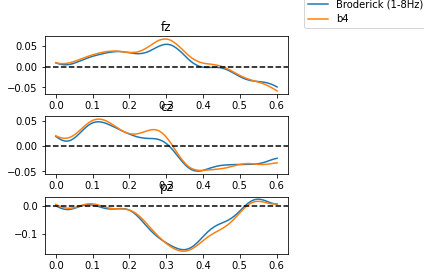

In [ ]:
# And plot the coefficient of the Temporal Response Functions found for three different models of word suprisal.
sd = 1.6
pl =1
nrow = 3
ncol = 2
widths = [0,3,0.1,0.1]
heights = [0,33,0.33,0.33]
# gr = grid.GridSpec(wspace= , hspace= width_ratios= , height_ratios= )
gri = {'wspace':0.5,'hspace':0.4,'width_ratios':[1,0.1]}
fig, axes = plt.subplots(nrow,ncol, squeeze = False, gridspec_kw = gri)
plot_curve(84,sd,axes[0,0],'fz')
plot_curve(0,sd,axes[1,0],'cz')
plot_curve(20,sd,axes[2,0],'pz')
axes[0,1].axis("off")
axes[1,1].axis("off")
axes[2,1].axis("off")
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1))
fig.show();

# Assignment 2

Study the temporal response functions you find for a model that uses Broderick's model of word surprisal versus one that uses the Bert model (with 4 words prior context). Do you observe the N400 component (negative polarization approximately 400 ms after word onset) in some of the channels? Are those the relevant channels? Do you find differences between the two models? 

Now consider the results you get with a model that simple assign uniform suprisal values to all words (i.e., it does not distinguish between suprising or unsurpring words): the data which you can find in the "static_100000.npy" file. Does that model change your assessment of the performance of the Broderick and Bert models?




# Extra

Below you find some code to plot to create brain plots; this code is provided as it might be useful later on, but it is currently still undocumented and needs to be studied in some detail to be sure about what we are plotting...

In [ ]:
#@title Helper function 6: plot_brain()

def plot_brain(a1, b1, sel, ax, the_title):
    # plot_coefs = np.tile(np.expand_dims(scores[1],1),78) - np.tile(np.expand_dims(scores[0],1),78)
    plot_coefs = coefs[sel]

    #c = np.mean([a1,b1])
    a = times> a1
    b = times< b1
    selection = np.flatnonzero(a & b)

    s1 = plot_coefs[:,0].shape[0]
    tmp = np.zeros((len(selection),s1))
    for i in range(len(selection)):
        tmp[i] = plot_coefs[:,selection[i]]

    mean_plot = np.mean(tmp,0)
     
    max_coef = plot_coefs.max()
    min_coef = plot_coefs.min()
    # Make a topographic map of coefficients for a given delay (see Fig 2C in [1])
    #ix_plot = np.argmin(np.abs(time_plot - times))
    mne.viz.plot_topomap(mean_plot, pos=info, axes=ax, show=False,
                         vmin=min_coef*1.2, vmax=max_coef*1.5, names = range(0,128), show_names=False, sensors=False)
    ax.set(title=the_title)
    mne.viz.tight_layout()

/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:385: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:385: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pick = np.zeros(nchan, dtype=np.bool)
/usr/local/lib/python3.7/dist-packages/mne/io/pick.py:385: Depre

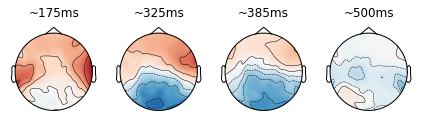

In [ ]:
sd = 1.6
pl =0
nrow = 3
ncol = 3
#gri = {'wspace':0.5,'hspace':0.4,'width_ratios':[1,2,0.1]}
fig, axes = plt.subplots(1,4, squeeze = False)
plot_brain(0.148,0.203,pl,axes[0,0],"~175ms")
plot_brain(0.297,0.352,pl,axes[0,1],"~325ms")
plot_brain(0.359,0.422,pl,axes[0,2],"~385ms")
plot_brain(0.477,0.531,pl,axes[0,3],"~500ms")